## IE614-Irbene analysis of initial land survey

In [46]:
from numpy import *
from matplotlib.pyplot import *
from numpy.linalg.linalg import norm
%matplotlib inline
import csv, re
def s(arr):
    '''Shorthand for printing array (with round brackets)'''
    return array2string(arr,
                        separator=",",
                        precision=3.7).replace("[ ","(").replace("]",")")

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

We extracted the labels from the DGN file (layer `RELJ_AATZ_####_TKST`); their coordinates were saved in a CSV; the conversion from `LKS92 / Latvia TM (EPSG:3059)` to `ETRS89 (EPSG:4258)` was done in QGIS.

In [3]:
with open('whitepoints.csv', 'r') as csv_file:
    csv_rows = [(row[6],
                 array([float(num) for num in [row[0],row[1],row[7]]]),
                 row[8]
                )
                for row in csv.reader(csv_file, delimiter=',')
                if 'X' not in row[0]]
print(len(csv_rows))
csv_rows[0:3]

1489


[('D3A6', array([ 21.85580805,  57.55293949,  16.08      ]), ''),
 ('D3B0', array([ 21.85584939,  57.55298378,  16.08      ]), ''),
 ('D3B1', array([ 21.85578828,  57.55299156,  15.98      ]), '')]

### Convert survey coordinates to ETRS xyz

We need to transform this to xyz for the rest of the analysis.

We will use the external library `pyproj` for this.

In [4]:
import pyproj
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

Put all the resulting positions in the variable `ecef_rows`:

In [5]:
ecef_rows = []
for (name, coord_latlonalt, cat) in csv_rows:
    if cat!='del':
        ecef_rows = ecef_rows + [(name, 
                                  array(pyproj.transform(lla,
                                            ecef,
                                            coord_latlonalt[0], # Longitude
                                            coord_latlonalt[1], # Latitude
                                            coord_latlonalt[2], # Altitude
                                            radians=False)),
                                  cat
                                 )
                                ]
print(len(ecef_rows))
ecef_rows[0:3]

1486


[('D3A6',
  array([ 3183643.90531284,  1276965.18087294,  5359201.73498731]),
  ''),
 ('D3B0',
  array([ 3183639.12057627,  1276965.92836726,  5359204.38142127]),
  ''),
 ('D3B1',
  array([ 3183639.75457585,  1276962.24044043,  5359204.76167339]),
  '')]

In [6]:
ecef_outline = []
for (name, coord_latlonalt, cat) in csv_rows:
    ecef_outline = ecef_outline + [(name, 
                              array(pyproj.transform(lla,
                                            ecef,
                                            coord_latlonalt[0], # Longitude
                                            coord_latlonalt[1], # Latitude
                                            coord_latlonalt[2], # Altitude
                                            radians=False)),
                              cat
                             )
                            ]
ecef_outline[0:3]

[('D3A6',
  array([ 3183643.90531284,  1276965.18087294,  5359201.73498731]),
  ''),
 ('D3B0',
  array([ 3183639.12057627,  1276965.92836726,  5359204.38142127]),
  ''),
 ('D3B1',
  array([ 3183639.75457585,  1276962.24044043,  5359204.76167339]),
  '')]

### Import features from DWG

In [7]:
import re

In [8]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [9]:
def wkttocoords(wktstring):
    '''
    Convert a linestring in WKT to a list of array coordinates.
    Converts from lat-long to XYZ
    '''
    nums = re.findall(r'\d+(?:\.\d*)?', wktstring)
    return [pyproj.transform(lla, ecef, chunk[0], chunk[1], 0, radians=False) for chunk in chunks(nums,3)]

In [10]:
with open('features.csv', 'r') as csv_file:
    features = [array(wkttocoords(row[0]))
                for row in csv.reader(csv_file, delimiter=',')
                if 'WKT' not in row[0]]
print(len(features))

43


In [11]:
with open('border.csv', 'r') as csv_file:
    features += [array(wkttocoords(row[0]))
                for row in csv.reader(csv_file, delimiter=',')
                if 'WKT' not in row[0]]
print(len(features))

44


### Survey coordinates statistics

The variable `position_dict` can be used to look up positions based on the name of the point. *fieldpoints_etrs* is an array of all 3D ETRS coordinates (with category=`3`, as marked manually in QGIS).

In [12]:
fieldlevels_etrs = array([row[1] for row in ecef_rows if row[2]=='fld4'])
alllevels_etrs = array([row[1] for row in ecef_rows])
mean_position = fieldlevels_etrs.mean(axis=0)
print('Mean position (ETRS89): ', mean_position)

Mean position (ETRS89):  [ 3183262.81579331  1276777.68140933  5359465.81959005]


And in geographic coordinates in radians and meters:

In [13]:
import lofargeo

In [14]:
geo_mean = lofargeo.geographic_from_xyz(mean_position)
print('''lat_rad : %(lat_rad).10f rad
lon_rad : %(lon_rad).10f rad
height_m: %(height_m).3f m''' % geo_mean)

lat_rad : 1.0045665001 rad
lon_rad : 0.3814464363 rad
height_m: 11.742 m


The normal vector to the WGS84 ellipsoid is then

In [15]:
ellipsoid_normal = lofargeo.normal_vector_ellipsoid(geo_mean['lon_rad'],
                                                    geo_mean['lat_rad'])
print("Normal to WGS84 ellipsoid:", ellipsoid_normal)

Normal to WGS84 ellipsoid: [ 0.49789762  0.1997022   0.84392949]


## Slope of the field

The first inspection of the data is done with respect to the plane parallel to the tangent plane of the WGS84 ellipsoid at the mean position of all measured points, that goes right through the mean coordinate of all measured points. We determine a transformation_matrix that ensures that transformed "x" will be pointing east, "y" towards geographic north, and "z" up and perpendicular to the tangent plane of the ellipsoid at the longitude and latitude of the mean position.

In [16]:
matrix_localnorth_to_etrs = lofargeo.projection_matrix(mean_position, ellipsoid_normal)
local_north_xyz = lofargeo.transform(alllevels_etrs,
                                     mean_position,
                                     matrix_localnorth_to_etrs.T)
local_north_xyz_field = lofargeo.transform(fieldlevels_etrs,
                                           mean_position,
                                           matrix_localnorth_to_etrs.T)
features_xyz = [lofargeo.transform(feature, mean_position, matrix_localnorth_to_etrs.T) for feature in features]

<IPython.core.display.Javascript object>


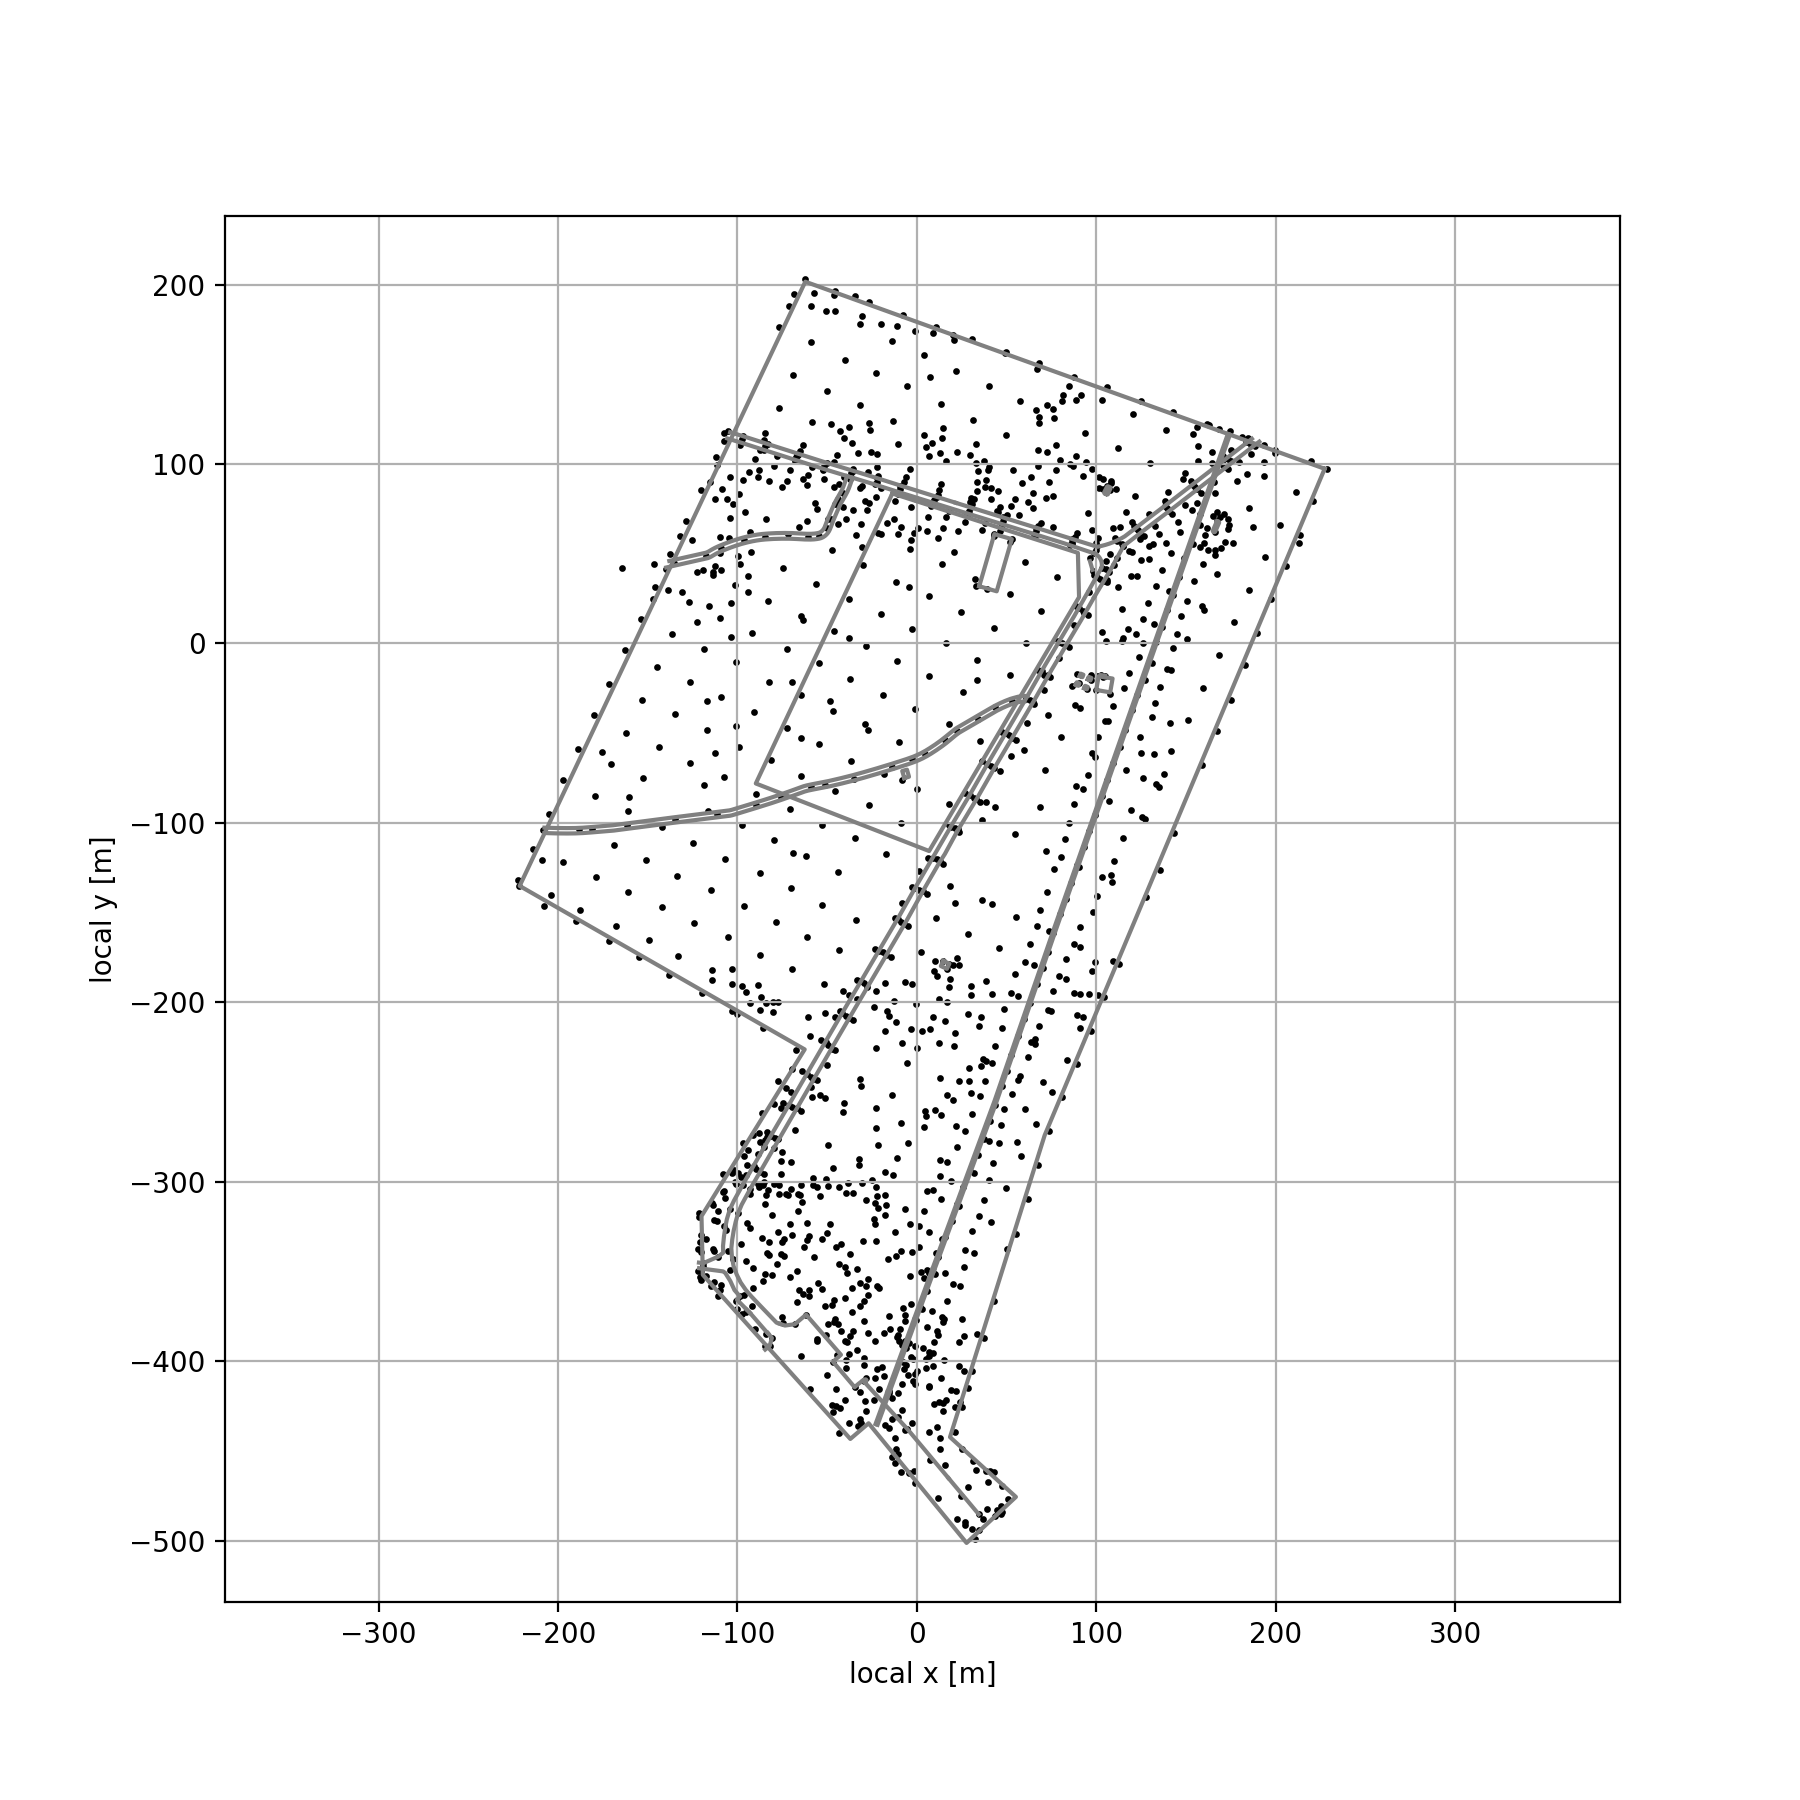

In [17]:
figure(figsize=(9,9))
scatter(local_north_xyz[:,0], local_north_xyz[:,1], s=2, c='k')

axis('equal')
autoscale(False)

for feature in features_xyz:
    plot(feature[:,0],feature[:,1], c='grey')
    
grid()

#title('LV614 initial site survey points\nMean position (ETRS89)= %s' % s(mean_position))
xlabel('local x [m]');
ylabel('local y [m]');

The following function interpolates between unstructured points in 3D space.

In [18]:
xyz_interpol_fn = lofargeo.interpolation_function(local_north_xyz)
x_m, y_m = meshgrid(arange(-160, 250, 2), arange(-200, 100, 2))
z_m = xyz_interpol_fn(x_m, y_m)

Now let's plot a map of elevation of all survey points relative to the mean position of the field points.

<IPython.core.display.Javascript object>


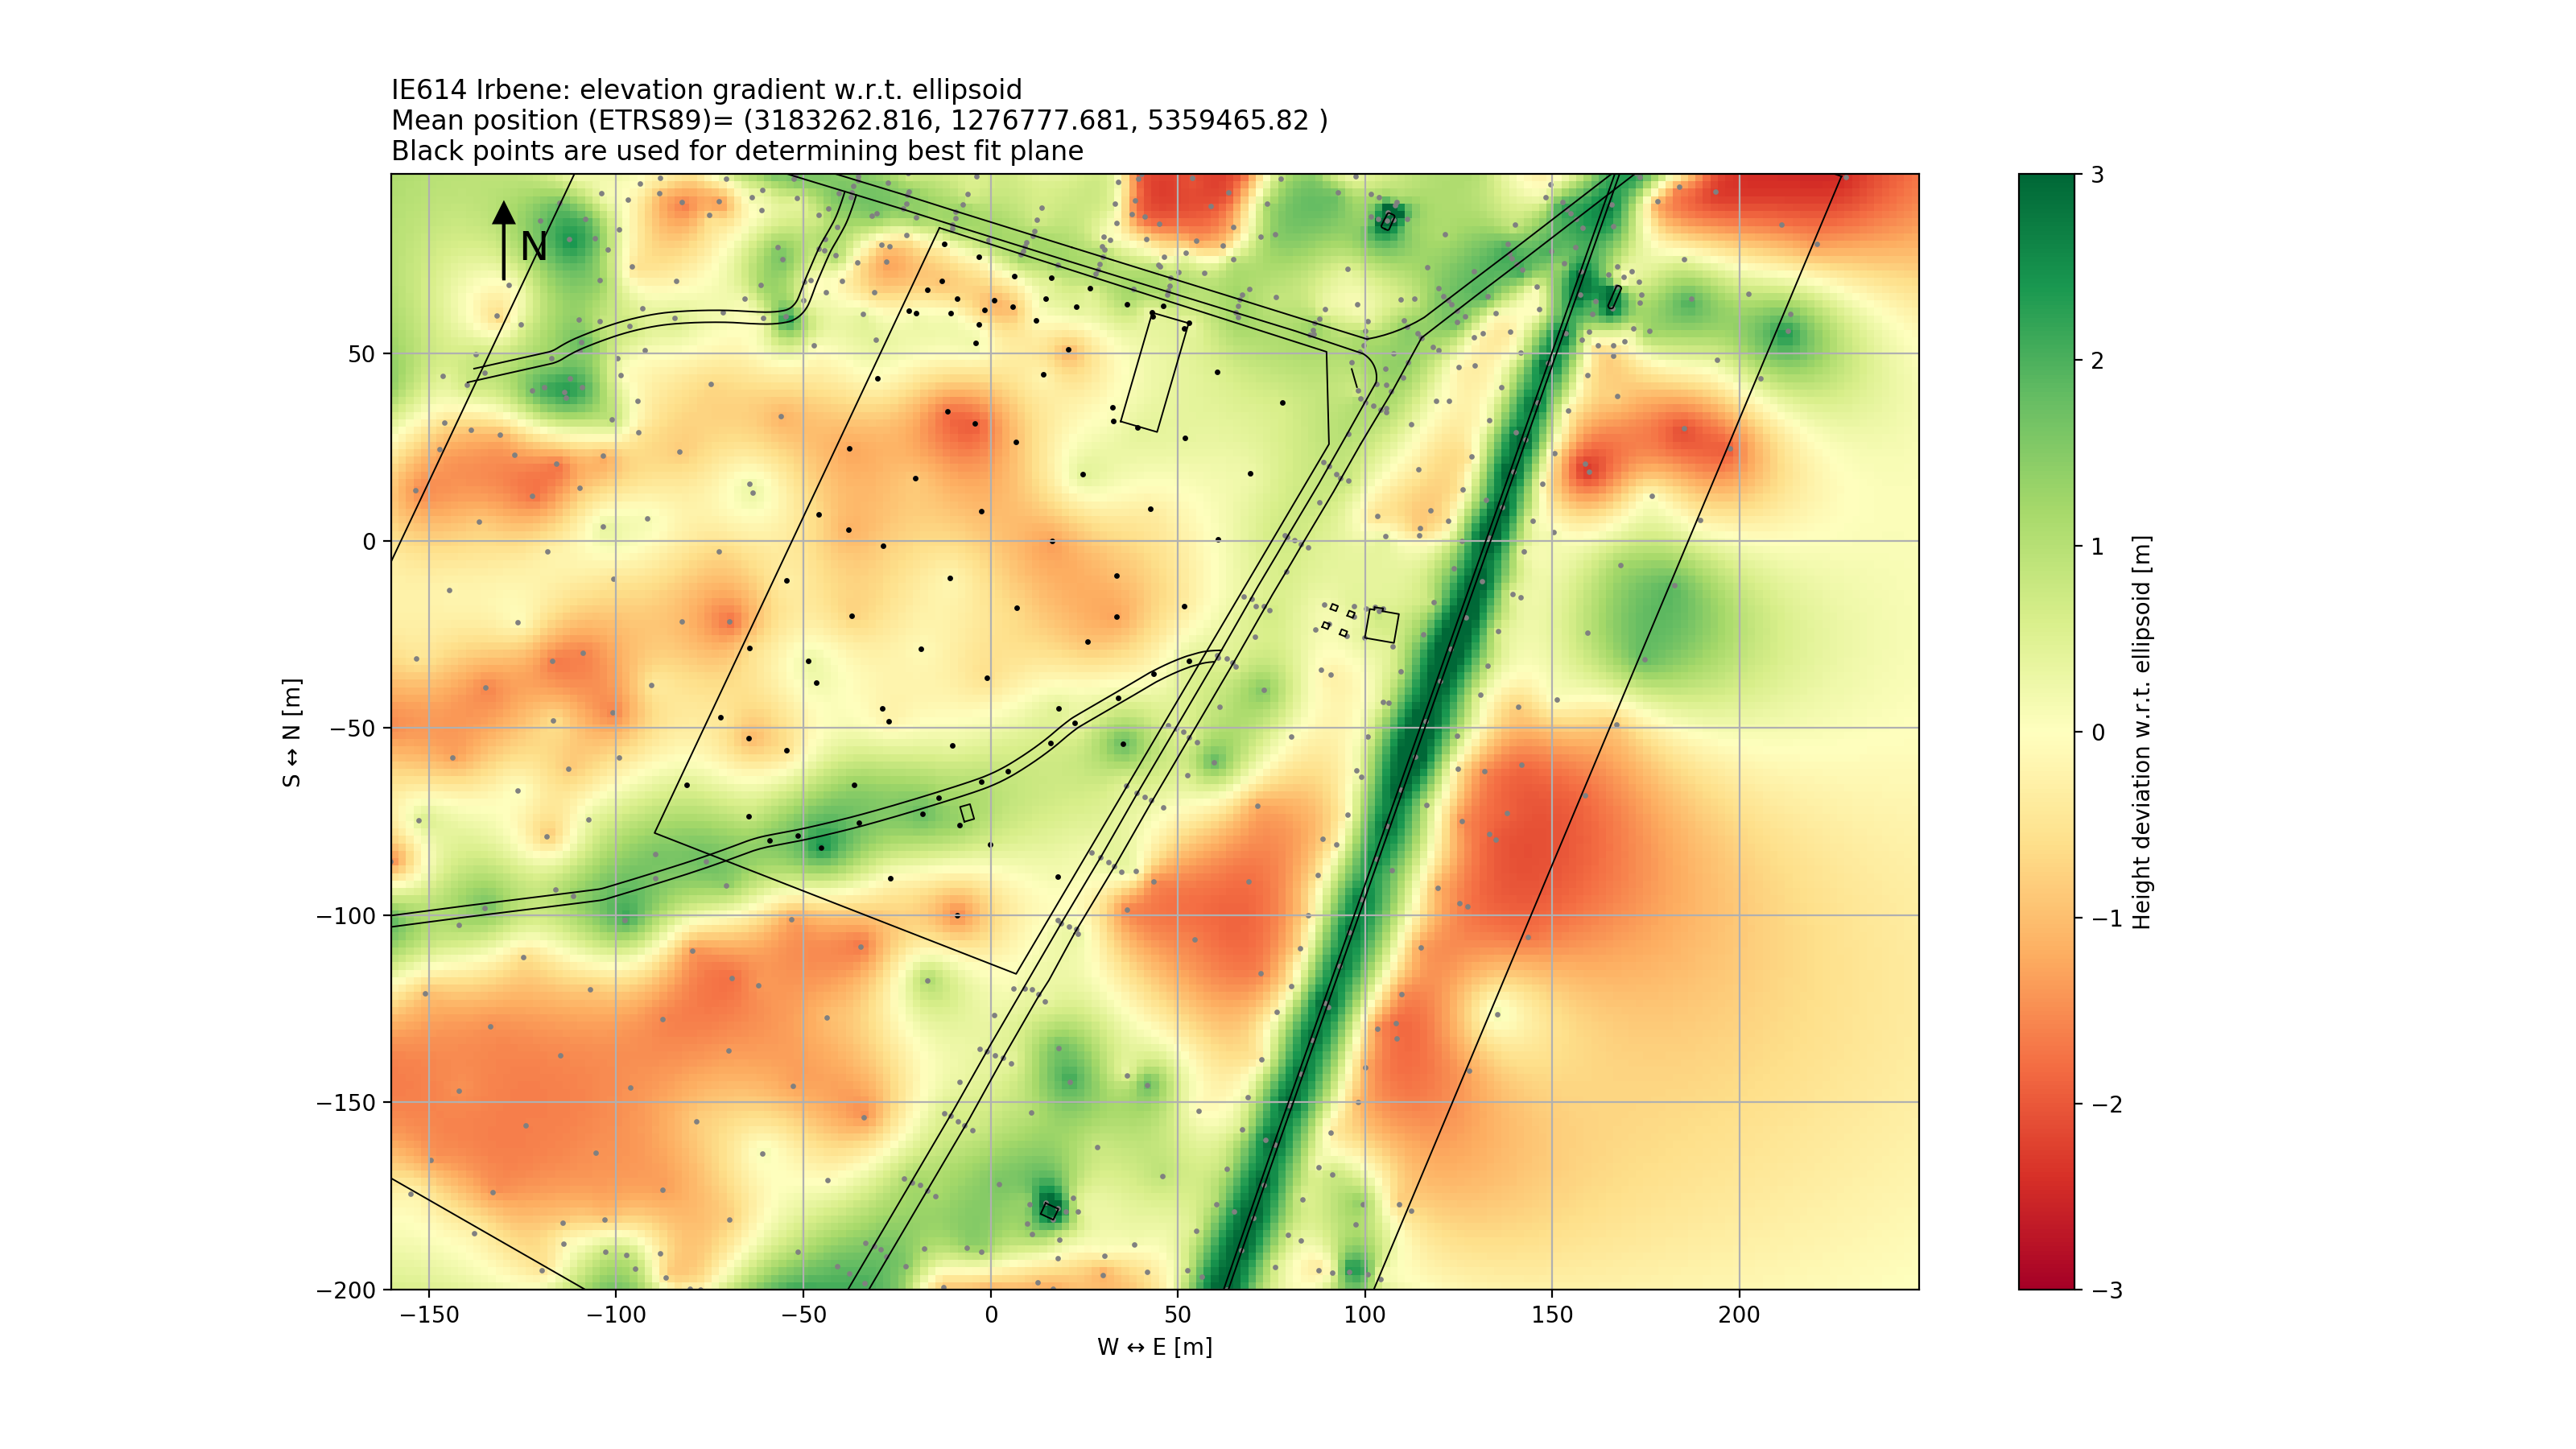

In [19]:
figure(figsize=[16,9])
imshow(z_m, origin='lower', cmap='RdYlGn', vmin=-3, vmax=3, extent=(x_m[0,0], x_m[0,-1], y_m[0,0], y_m[-1,0]))

autoscale(False)

for feature in features_xyz:
    plot(feature[:,0],feature[:,1], c='black', lw=0.7)

cb = colorbar()
cb.set_label('Height deviation w.r.t. ellipsoid [m]')

xlabel('W ↔︎ E [m]');
ylabel('S ↔︎ N [m]');

grid()

title('IE614 Irbene: elevation gradient w.r.t. ellipsoid\nMean position (ETRS89)= %s\n'%
      s(mean_position) + 'Black points are used for determining best fit plane', loc='left')

arrow(-130,70,0,15,linewidth = 1.5,head_width=5,head_length=5,color='k')
text(-126,75,"N",fontsize=18)

scatter(local_north_xyz[:,0], local_north_xyz[:,1], s=2, c='grey');
scatter(local_north_xyz_field[:,0], local_north_xyz_field[:,1], s=2, c='k');

## Best fit plane and deviations from that plane

In [20]:
solution = lofargeo.fit_plane(fieldlevels_etrs)
matrix_pqr_to_etrs = lofargeo.projection_matrix(lofargeo.LOFAR_XYZ0_m, solution['normal'])
print('Normal vector:', solution['normal'])
print('Mean position:', solution['mean'])
print('Rotation matrix PQR to ETRS:\n', matrix_pqr_to_etrs)

Normal vector: [ 0.49453154  0.19324931  0.84740384]
Mean position: [ 3183262.81579331  1276777.68140933  5359465.81959005]
Rotation matrix PQR to ETRS:
 [[-0.18690025 -0.84882675  0.49453154]
 [ 0.97580498 -0.10227094  0.19324931]
 [-0.11345898  0.51868468  0.84740384]]


The best-fit plane is almost 'flat' w.r.t. the ellipsoid tangent plane:

In [21]:
rad2deg(arccos(dot(solution['normal'],ellipsoid_normal)))

0.46208140440094253

## Convert all survey points, plot

In [22]:
station_pqr = lofargeo.transform(alllevels_etrs,
                                 solution['mean'],
                                 matrix_pqr_to_etrs.T)
station_height_deviation_fn = lofargeo.interpolation_function(station_pqr)
print('p range: ', station_pqr[:,0].min(),'–', station_pqr[:,0].max())
print('q range: ', station_pqr[:,1].min(),'–', station_pqr[:,1].max())

p range:  -187.60353298 – 201.3550291
q range:  -479.631364172 – 184.304182774


In [23]:
features_pqr = [lofargeo.transform(feature, solution['mean'], matrix_pqr_to_etrs.T) 
                for feature in features]

In [24]:
[pmin,pmax,qmin,qmax] = [-100, 150, -150, 110]
p_m, q_m = meshgrid(arange(pmin, pmax, 2), arange(qmin, qmax, 2))
r_m = station_height_deviation_fn(p_m, q_m)

Choose some centers:

In [25]:
chba_pqr = array([20,20,0])
clba_pqr = array([-10,-55,0])

### Container coordinates

We pick the container direction to be parallel to the road, which happens to be encoded in `features_pqr[37]`:

In [26]:
container_diry=features_pqr[37][20,:]-features_pqr[37][10,:]
container_diry[2]=0
container_diry/=norm(container_diry)

In [27]:
container_dirx = array([container_diry[1], -container_diry[0], 0])

In [28]:
container_origin = array([37,-30,0])

In [31]:
container_pqr = array([container_origin,
                       container_origin + container_dirx*3.5,
                       container_origin + container_dirx*3.5 + container_diry*7.5,
                       container_origin + container_diry*7.5,
                       container_origin])

In [37]:
Polygon(container_pqr[:,0:2])

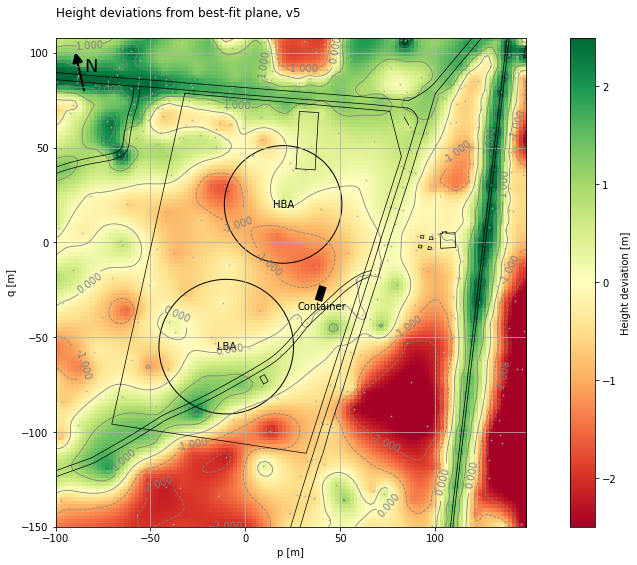

In [47]:
figure(figsize=[16,9])
imshow(r_m, origin='lower', vmin=-2.5, vmax=2.5, extent=(pmin, pmax-2, qmin, qmax-2),
       cmap='RdYlGn')
autoscale(False)

for feature in features_pqr:
    plot(feature[:,0],feature[:,1], c='black', lw=0.7)

grid()
cb = colorbar()
cb.set_label('Height deviation [m]')
cnt = contour(p_m, q_m, r_m, colors='grey', linewidths=.8,
              levels=[-2,-1,0,1,2,3]) #, levels=arange(-1.0, +1.0, 0.05))
cnt.clabel(inline=True)
xlabel('p [m]')
ylabel('q [m]')
scatter(station_pqr[:,0], station_pqr[:,1], s=0.5, c='darkgrey')

# HBA and LBA field
ax=gca()
text(clba_pqr[0],clba_pqr[1],"LBA",ha='center',va='center')
ax.add_artist(Circle(clba_pqr[0:2],71./2, fill=False))
text(chba_pqr[0],chba_pqr[1],"HBA",ha='center',va='center')
ax.add_artist(Circle(chba_pqr[0:2],62./2, fill=False))

# Container
ax.add_artist(Polygon(container_pqr[:,0:2], color='black'))
text(container_pqr[1,0],container_pqr[1,1],"Container", ha='center', va='top')

# North arrow, code borrowed from below
matrix_localnorth_to_pqr = dot(matrix_pqr_to_etrs.T,matrix_localnorth_to_etrs)
localnorth_pqr = dot(matrix_localnorth_to_pqr,[0,1,0])
arrow(-85,80,15*localnorth_pqr[0],15*localnorth_pqr[1],linewidth = 1.5,head_width=5,head_length=5,color='k')
text(-85,90,"N",fontsize=18)

# Container


title('''Height deviations from best-fit plane, v5\n''', loc='left');

savefig("deviation-v5.pdf")

## Export coordinates of centers to ETRS

In [35]:
[clba_etrs,chba_etrs]=lofargeo.transform(array([clba_pqr,chba_pqr]),zeros(3),matrix_pqr_to_etrs)+solution['mean']

In [36]:
def tolatlong(coord_etrs):
    '''Convert ETRS XYZ-coordinates to a list with latitude and longitude in degrees'''
    latlondict=lofargeo.geographic_from_xyz(coord_etrs)
    return [rad2deg(latlondict['lat_rad']),rad2deg(latlondict['lon_rad'])]

In [37]:
with open('centers.csv','w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Name','Lat','Long','Diam'])
    csvwriter.writerow(['CLBA']+list(map(str,tolatlong(clba_etrs)))+[35.5])
    csvwriter.writerow(['CHBA']+list(map(str,tolatlong(chba_etrs)))+[31])

In [38]:
container_etrs = lofargeo.transform(container_pqr, zeros(3), matrix_pqr_to_etrs) + solution['mean']

In [39]:
with open('container.csv','w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Name','Lat','Long'])
    for num, cpt_etrs in enumerate(container_etrs):
        csvwriter.writerow([num]+list(map(str,tolatlong(cpt_etrs))))

## Reference direction

The reference direction is the northern bisector of the X- and Y- dipoles. At LOFAR core station CS002 LBA, the reference direction coincides with true north, but elsewhere there is a slight deviation to ensure that all dipoles in LOFAR are oriented as similarly as possible. In this section, we determine the deviation between the reference direction (the "q" axis in the pqr system) and geographic north in the ETRS89 reference system.

We will determine the angle between the reference direction of the station (which is (0,1,0) in the pqr system) and ETRS89 north. To do this, we combine the existing conversions from the *local-north* frame to ETRS, and the conversion from ETRS to the pqr system:

In [26]:
matrix_localnorth_to_pqr = dot(matrix_pqr_to_etrs.T,matrix_localnorth_to_etrs)

To see the q-vector in the *local-north* frame, we apply the inverse conversion (so pqr to *localnorth*) to the vector (0,1,0):

In [27]:
q_xyz = dot(matrix_localnorth_to_pqr.T,[0,1,0])

Since the reference plane (r=0) makes only a slight angle with the tangent plane to the ellipsoid (z=0), the third component of `q_xyz` is small:

In [28]:
q_xyz[2]

0.0019602995913013954

We can project the q-vector onto the tangent plane to the ellipsoid by setting its last component to 0:

In [29]:
q_xyz[2] = 0

Now the angle of the q-vector with the north-axis is given by

In [30]:
deviation_xyz = rad2deg(arctan(q_xyz[0]/q_xyz[1]))

In [31]:
if deviation_xyz >=0:
    eastorwest = 'east'
else:
    eastorwest = 'west'

To draw a north-arrow in the pqr plane, we use the inverse transformation (so *localnorth* to pqr).

In [32]:
localnorth_pqr = dot(matrix_localnorth_to_pqr,[0,1,0])
localnorth_pqr[2] = 0 # Project onto to r=0 plane
deviation_pqr = rad2deg(arctan(localnorth_pqr[0]/localnorth_pqr[1]))

Because the reference plane makes only a small angle with the tangent plane to the ellispoid, these numbers are very similar (but with opposite sign):

In [33]:
-deviation_xyz - deviation_pqr

0.00027419634799841219

To represent this graphically:

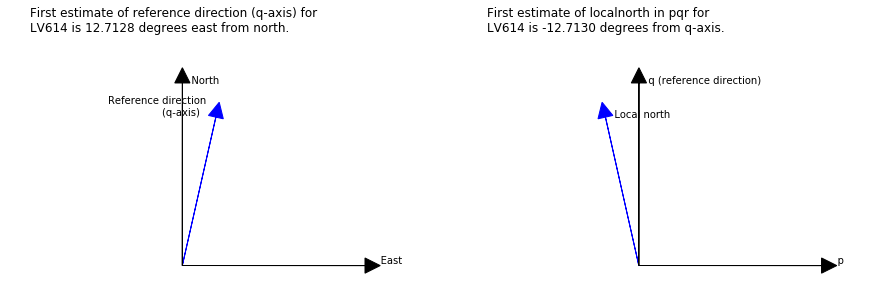

In [34]:
fig, (ax_xyz, ax_pqr) = subplots(1,2, figsize=(15,15));
#figure(figsize=(5,5));

for ax in [ax_xyz, ax_pqr]:
  ax.set_aspect('equal', adjustable='box')
  ax.set_xlim([-1.0,1.5]);
  ax.set_ylim([-0.1,1.5]);
  ax.axis('off')

ax_xyz.arrow(0, 0, q_xyz[0], q_xyz[1], head_width=0.1, head_length=0.1,
             fc='b', ec='b');
ax_xyz.text(          q_xyz[0], q_xyz[1], 'Reference direction   \n(q-axis)     ', ha='right', va='bottom')
ax_xyz.arrow(0, 0, 0, 1.2, head_width=0.1, head_length=0.1, fc='k', ec='k');
ax_xyz.text(          0, 1.2, '   North');
ax_xyz.arrow(0, 0, 1.2, 0, head_width=0.1, head_length=0.1, fc='k', ec='k');
ax_xyz.text(          1.2, 0, '     East', va='bottom');
ax_xyz.set_title("First estimate of reference direction (q-axis) for\nLV614 is\
 %.4f degrees %s from north."%(abs(deviation_xyz), eastorwest), loc='left');

ax_pqr.arrow(0, 0, localnorth_pqr[0], localnorth_pqr[1], head_width=0.1, head_length=0.1,
             fc='b', ec='b');
ax_pqr.text(       localnorth_pqr[0], localnorth_pqr[1], '   Local north', ha='left')
ax_pqr.arrow(0, 0, 0, 1.2, head_width=0.1, head_length=0.1, fc='k', ec='k');
ax_pqr.text(          0, 1.2, '   q (reference direction)');
ax_pqr.arrow(0, 0, 1.2, 0, head_width=0.1, head_length=0.1, fc='k', ec='k');
ax_pqr.text(          1.2, 0, '     p', va='bottom');
ax_pqr.set_title("First estimate of localnorth in pqr for\nLV614 is\
 %.4f degrees from q-axis."%(deviation_pqr), loc='left');

## Reference direction

Reason we need low minimal elevation (a piece of TaQL):

```
> meas.direction("J2000",[240deg,20deg],"AZEL",datetime(),[6.8698deg,52.915deg],"ITRFLL")
3.02059 rad, -0.00879145 rad]

> meas.direction("AZEL",
               [3.02059 rad, -0.00879145 rad],"J2000",
               datetime(),
               [21.8549048796deg,57.5569589207deg],"ITRFLL") deg
[-107.834 deg, 10.3188 deg]
```